# Citibike Project - Using DuckDB to analyze spatial relationships of the dataset

## Imports

In [15]:
import duckdb
import leafmap
import polars as pl
import leafmap
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import ipyleaflet
from ipyleaflet import Marker, Popup
import ipywidgets as widgets
from IPython.display import display

## Import data

In [16]:
ride = pl.read_parquet('/Users/sra/files/projects/citibike_project/combined/group1_combined/group1_pl_ridenorm.parquet')
print('original shape: ', ride.shape)
ride.head()

original shape:  (55800085, 7)


ride_id,started_at,ended_at,start_station_id,end_station_id,ridertype,biketype
str,datetime[μs],datetime[μs],f64,f64,i32,i32
"""26A3DC47FE0EA3A3""",2021-05-13 12:48:08,2021-05-13 13:07:37,6173.08,5515.02,0,2
"""A99F2E1D627B088F""",2021-05-16 08:30:13,2021-05-16 08:45:47,6286.02,6873.01,0,2
"""43E79A45997B7390""",2021-05-01 08:38:14,2021-05-01 08:54:27,6286.02,6873.01,0,2
"""8B3CC649F4F58816""",2021-05-09 08:12:31,2021-05-09 08:27:05,6286.02,6873.01,0,2
"""7101C98F057486F4""",2021-05-27 07:52:27,2021-05-27 08:09:01,7636.05,7020.09,0,2


In [17]:
station = pl.read_parquet('/Users/sra/files/projects/citibike_project/combined/group1_combined/group1_pl_stationnorm.parquet')
print('original shape: ', station.shape)
station.head()

original shape:  (55800085, 4)


start_station_name,start_station_id,start_lat,start_lng
str,f64,f64,f64
"""Broadway & W 25 St""",6173.08,40.742868,-73.989186
"""46 Ave & 5 St""",6286.02,40.74731,-73.95451
"""46 Ave & 5 St""",6286.02,40.74731,-73.95451
"""46 Ave & 5 St""",6286.02,40.74731,-73.95451
"""E 123 St & Lexington Ave""",7636.05,40.802926,-73.9379


In [18]:
station.select(
    pl.col('start_station_name').n_unique()
)

start_station_name
u32
2038


Get a reduced dataset with just the first instance of a unique station name: 

In [19]:
unique_stations = station['start_station_name'].unique().to_list()

first_rows = []

for unique_stat in unique_stations:
    # select just the first row that matches
    first_row = station.filter(pl.col('start_station_name') == unique_stat).head(1)
    if first_row.height > 0:
        first_rows.append(first_row.to_dicts()[0])

unique_stations = pl.DataFrame(first_rows)
print(unique_stations.shape)
unique_stations.head()

(2037, 4)


start_station_name,start_station_id,start_lat,start_lng
str,f64,f64,f64
"""48 St & 37 Ave""",6435.02,40.751555,-73.915026
"""Cliff St & Fulton St""",5065.14,40.70838,-74.00495
"""Broadway & W 38 St""",6441.05,40.752996,-73.987216
"""Carlton Ave & Park Ave""",4732.04,40.695807,-73.973555
"""44 St & 6 Ave""",3233.06,40.647105,-74.004483


We have some data that is normalized with the columns 'ridertype' and 'biketype'. We will add that data to the table using DuckDB.

In [39]:
# create tables
with duckdb.connect('citibike.db') as con:
    con.execute("drop table if exists rider")
    con.execute("""
        create table rider (
            type varchar(255),
            id int
        )
    """)

    # add data to table
    con.execute('''insert into rider values ('member', 0), ('casual', 1)''')

with duckdb.connect('citibike.db') as con:
    con.execute("drop table if exists bike")
    con.execute("""
        create table bike (
            type varchar(255),
            id int
        )
    """)

    # add data to table
    con.execute(
        '''insert into bike values 
        ('classic', 0), 
        ('electric', 1), 
        ('unknown', 2)''')
    
with duckdb.connect('citibike.db') as con:
    print("Rider Table:")
    print(con.execute("select * from rider").fetchall())
    
    print("Bike Table:")
    print(con.execute("select * from bike").fetchall())

Rider Table:
[('member', 0), ('casual', 1)]
Bike Table:
[('classic', 0), ('electric', 1), ('unknown', 2)]


### Visualize the stations

Get the centroid of NYC for correct viewing location:

In [21]:
# read in centroid of NYC
centroid_df = pd.read_csv('../data/nyc_centroid.csv')
x, y = centroid_df.loc[0, 'x'], centroid_df.loc[0, 'y']

centroid = gpd.GeoDataFrame([{'geometry': Point(x, y)}], crs='EPSG:4326')

latitude = centroid.geometry.iloc[0].y
longitude = centroid.geometry.iloc[0].x
# centroid.explore()

Convert station dataframe (in polars) to geopandas and view it:

In [22]:
# convert station df (polars) to geopandas
geometry = [Point(x, y) for x, y in zip(unique_stations['start_lng'], 
                                        unique_stations['start_lat'])]
station_gdf = gpd.GeoDataFrame(unique_stations.to_pandas(),
                               geometry=geometry, 
                               crs='EPSG:4326')

<Axes: >

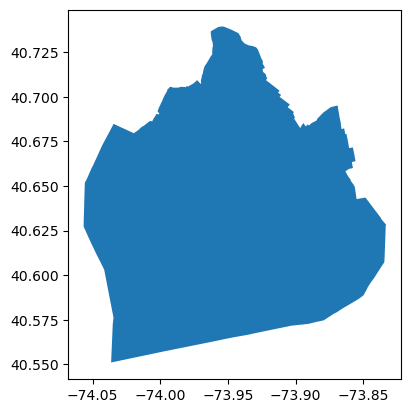

In [28]:
# read in Brooklyn outline
brooklyn_outline = gpd.read_file('../data/brooklyn_outline.gpkg', 
                                 layer='brooklyn_outline')

# convert to geojson
brooklyn_outline.to_file('../data/brooklyn_outline.geojson', driver='GeoJSON')
brooklyn_outline.plot()

In [41]:
m = leafmap.Map(center=[latitude, longitude], zoom=11)

m.add_geojson('../data/brooklyn_outline.geojson', layer_name='Brooklyn Outline')
m.add_marker_cluster(station_gdf, x='start_lng', y='start_lat', 
                     layer_name='Citibike Stations')

m

Map(center=[40.663919770970146, -73.93835141651655], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Use PostGIS to get the intersection of the stations with the Brooklyn borough outline

In [40]:
# create tables
with duckdb.connect('citibike.db') as con:
    con.install_extension('spatial')
    con.load_extension('spatial')
    con.sql('show tables;')

In [13]:
# # create a leafmap map
# m = leafmap.Map(center=[latitude, longitude], zoom=10)

# # add markers for each station
# for idx, row in station_gdf.iterrows():
#     # create a popup widget using html widget
#     popup = Popup(child=widgets.HTML(value=row['start_station_name']),
#                   close_button=True, 
#                   auto_close=True, 
#                   close_on_escape_key=True)
    
#     # add marker with popup
#     marker = Marker(location=[row.geometry.y, row.geometry.x])  # latitude, longitude
#     marker.popup = popup  # attach the popup to the marker
    
#     m.add(marker)

# # display the map
# # print('Map displayed successfully.')
# # display(m)

In [ ]:

# ride = ride.drop_nulls(subset=['county_fips'])
# pres.head()

# # filter for mode == "TOTAL"
# pres = pres.filter(pl.col('mode') == 'TOTAL')

# # pivot 'party' column to create separate columns
# pres = pres.pivot(
#     values=['candidatevotes', 'totalvotes'],  # columns to be spread across new columns
#     index=['year', 'state', 'state_po', 'county_name', 'county_fips', 'office'],  # grouping columns
#     columns='party',  # column whose values will become new column names
# ).rename({
#     'candidatevotes_party_DEMOCRAT': 'd',
#     'candidatevotes_party_REPUBLICAN': 'r',
#     'candidatevotes_party_GREEN':'g',
#     'candidatevotes_party_OTHER': 'o',
#     'candidatevotes_party_LIBERTARIAN': 'l',
#     'totalvotes_party_DEMOCRAT': 'total_d',
#     'totalvotes_party_REPUBLICAN': 'total_r',
#     'totalvotes_party_GREEN': 'total_g',
#     'totalvotes_party_OTHER': 'total_o',
#     'totalvotes_party_LIBERTARIAN': 'total_l'
# }).drop(['office', 'state_po', 
#          # 'county_name',  'state',
#          'total_d', 'total_r', 'total_g', 'total_o', 'total_l',
#          'g', 'o', 'l'
# ]).cast({'year': pl.Int32})

# # pad the 'county_fips' column to ensure all strings are 5 digits
# pres = pres.with_columns(
#     pl.col("county_fips").cast(pl.Utf8).str.zfill(5).alias("county_fips")
# )

# # get order of colums
# col_order = pres.columns

# pres